In [ ]:
!pip install transformers
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import evaluate
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# ===============================
# Evaluation Metrics
# ===============================
print(transformers.__version__)
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    preds = np.argmax(logits, axis=1)
    acc = acc_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1_macro = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    f1_weighted = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted}

4.56.1


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# ===============================
# Loading data
# ===============================
DATASET_NAME = "ag_news"
raw = load_dataset(DATASET_NAME)
split = raw["train"].train_test_split(test_size=0.08, seed=42)
train_ds = split["train"]
val_ds = split["test"]
test_ds = raw["test"]

label_names = train_ds.features["label"].names
num_labels = len(label_names)

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# ===============================
# Tokenization
# ===============================
def tokenize_datasets(model_ckpt, train_ds, val_ds, test_ds, max_length=128):
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True)
    def _tok(batch):
        return tokenizer(batch["text"], truncation=True, padding='max_length', max_length=max_length)
    t_train = train_ds.map(_tok, batched=True, batch_size=1000)
    t_val   = val_ds.map(_tok, batched=True, batch_size=1000)
    t_test  = test_ds.map(_tok, batched=True, batch_size=1000)
    t_train.set_format(type="torch", columns=tokenizer.model_input_names + ["label"])
    t_val.set_format(type="torch", columns=tokenizer.model_input_names + ["label"])
    t_test.set_format(type="torch", columns=tokenizer.model_input_names + ["label"])
    return tokenizer, t_train, t_val, t_test

In [ ]:
# ===============================
# Fine-tuning model
# ===============================
def fine_tune_resume(model_ckpt, outdir, tokenizer, train_dataset, val_dataset, test_dataset,
                     num_labels, epochs, per_device_batch, lr, resume_from_checkpoint=None):
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)

    training_args = TrainingArguments(
        output_dir=outdir,
        eval_strategy="epoch",           # Automatic verification at each epoch
        save_strategy="epoch",           # Save checkpoints at each epoch
        save_total_limit=5,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        per_device_train_batch_size=per_device_batch,
        per_device_eval_batch_size=per_device_batch,
        learning_rate=lr,
        weight_decay=0.01,
        num_train_epochs=epochs,
        fp16=True,
        logging_dir=f"{outdir}/logs",
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # ===============================
    # determine whether to resume
    # ===============================
    if resume_from_checkpoint:
        print(f"Resuming training from checkpoint: {resume_from_checkpoint}")
    else:
        print("Starting training from scratch")

    trainer.train(resume_from_checkpoint=resume_from_checkpoint)

    # ===============================
    # Test set evaluation
    # ===============================
    pred = trainer.predict(test_dataset)
    print("Final Test metrics:", pred.metrics)

    return trainer, model, pred

In [ ]:
# ===============================
# Confusion Matrix & Error Analysis
# ===============================
def plot_confusion_matrix(predictions, labels, label_names, title="Confusion Matrix"):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

def error_analysis(preds, labels, dataset, text_column="text", label_names=None, n_samples=10):
    import random

    errors = []

    # Text
    if text_column in dataset.column_names:
        texts = dataset[text_column]
    else:
        texts = [f"[No {text_column}, sample #{i}]" for i in range(len(dataset))]

    for i, (p, l) in enumerate(zip(preds, labels)):
        if p != l:
            errors.append({
                "text": texts[i],
                "true_label": label_names[l] if label_names else l,
                "pred_label": label_names[p] if label_names else p
            })

    sample_errors = random.sample(errors, min(n_samples, len(errors)))

    for e in sample_errors:
        print(f"Text: {e['text']}")
        print(f" True: {e['true_label']} | Pred: {e['pred_label']}")
        print("-" * 50)

    return errors



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/110400 [00:00<?, ? examples/s]

Map:   0%|          | 0/9600 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training from scratch


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.187300,0.184443,0.938021,0.937609,0.937883
2,0.133700,0.178672,0.944375,0.944121,0.944379
3,0.090400,0.197675,0.944896,0.944653,0.944894


Final Test metrics: {'test_loss': 0.18460433185100555, 'test_accuracy': 0.9448684210526316, 'test_f1_macro': 0.9449029081176249, 'test_f1_weighted': 0.9449029081176248, 'test_runtime': 6.1629, 'test_samples_per_second': 1233.176, 'test_steps_per_second': 38.618}


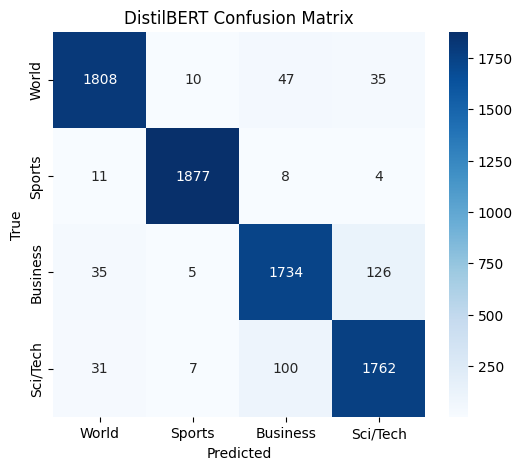

In [ ]:
# ===============================
# DistilBERT Fine-tuning
# ===============================
DISTIL_CKPT = "distilbert-base-uncased"
DISTIL_LR = 2e-5
DISTIL_BATCH = 32
DISTIL_EPOCHS = 3

tokenizer_distil, t_train_distil, t_val_distil, t_test_distil = tokenize_datasets(
    DISTIL_CKPT, train_ds, val_ds, test_ds
)

trainer_distil, model_distil, pred_distil = fine_tune_resume(
    DISTIL_CKPT, "./checkpoints/distilbert", tokenizer_distil,
    t_train_distil, t_val_distil, t_test_distil, num_labels,
    epochs=DISTIL_EPOCHS, per_device_batch=DISTIL_BATCH, lr=DISTIL_LR,
    resume_from_checkpoint=None  # First Training
)

# Confusion Matrix & Error Analysis
distil_preds = np.argmax(pred_distil.predictions, axis=1)
plot_confusion_matrix(distil_preds, pred_distil.label_ids, label_names, title="DistilBERT Confusion Matrix")

In [ ]:
errors_distil = error_analysis(distil_preds, pred_distil.label_ids, test_ds, label_names=label_names)

Text: Press review 0850CET--The seizure of fake Nike sportswear by the Customs Department was one of the main stories on Wednesday #39;s newspapers. L-Orizzont published 
 True: Sci/Tech | Pred: Sports
--------------------------------------------------
Text: UBS pays 265 million dollars for Schwab capital markets business (AFP) AFP - Swiss banking group UBS said that it had paid 265 million dollars (219 million euros) to buy SoundView, the capital markets division of online broker Charles Schwab to strengthen its position on the US Nasdaq market.
 True: Business | Pred: Sci/Tech
--------------------------------------------------
Text: Caterpillar snaps up another remanufacturer of engines PEORIA - Caterpillar Inc. said Wednesday it will acquire a South Carolina remanufacturer of engines and automatic transmissions, increasing its US employment base by 500 people. 
 True: Sci/Tech | Pred: Business
--------------------------------------------------
Text: Bush Signs Internet Access Tax Ba

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/110400 [00:00<?, ? examples/s]

Map:   0%|          | 0/9600 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training from scratch


W0912 16:02:41.962000 880 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.171300,0.179866,0.942187,0.941885,0.942137
2,0.093800,0.203881,0.947500,0.947280,0.947526
3,0.045300,0.345240,0.947292,0.947078,0.947321


Final Test metrics: {'test_loss': 0.20002830028533936, 'test_accuracy': 0.9457894736842105, 'test_f1_macro': 0.9457597734458655, 'test_f1_weighted': 0.9457597734458654, 'test_runtime': 21.5786, 'test_samples_per_second': 352.201, 'test_steps_per_second': 22.013}


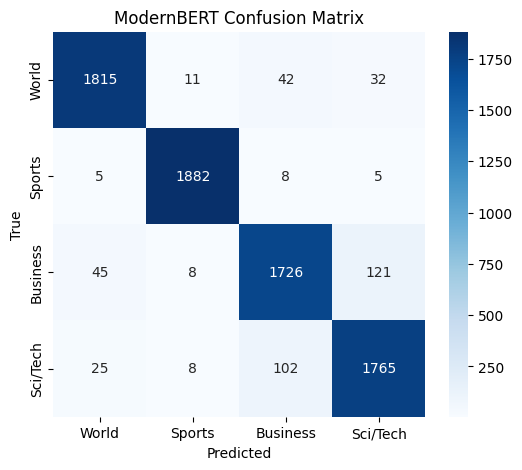

In [ ]:
# ===============================
# ModernBERT Fine-tuning
# ===============================
import torch._dynamo
torch._dynamo.config.suppress_errors = True

MODERN_CKPT = "answerdotai/ModernBERT-base"
MODERN_LR = 3e-5
MODERN_BATCH = 16
MODERN_EPOCHS = 3

tokenizer_modern, t_train_modern, t_val_modern, t_test_modern = tokenize_datasets(
    MODERN_CKPT, train_ds, val_ds, test_ds
)

trainer_modern, model_modern, pred_modern = fine_tune_resume(
    MODERN_CKPT, "./checkpoints/modernbert", tokenizer_modern,
    t_train_modern, t_val_modern, t_test_modern, num_labels,
    epochs=MODERN_EPOCHS, per_device_batch=MODERN_BATCH, lr=MODERN_LR,
    resume_from_checkpoint=None  # First Training
)

# Confusion Matrix & Error Analysis
modern_preds = np.argmax(pred_modern.predictions, axis=1)
plot_confusion_matrix(modern_preds, pred_modern.label_ids, label_names, title="ModernBERT Confusion Matrix")

In [ ]:
errors_modern = error_analysis(modern_preds, pred_modern.label_ids, test_ds, label_names=label_names)

Text: No tax on Internet access until at least 2007 Consumers won #39;t have to pay a tax to log on to the Internet until at least 2007, after Congress voted Friday to renew a recently lapsed ban on Internet taxation.
 True: Business | Pred: Sci/Tech
--------------------------------------------------
Text: Software Service Aims to Outfox Caller ID A new computerized service enables customers to create phony outbound phone numbers in order to mask their telephone identities.
 True: Business | Pred: Sci/Tech
--------------------------------------------------
Text: Caterpillar snaps up another remanufacturer of engines PEORIA - Caterpillar Inc. said Wednesday it will acquire a South Carolina remanufacturer of engines and automatic transmissions, increasing its US employment base by 500 people. 
 True: Sci/Tech | Pred: Business
--------------------------------------------------
Text: Prime minister says Australia faces tough economic year in 2005 (AFP) AFP - Prime Minister John Howard warn

In [ ]:
# %% Evaluation and comparison（accuracy / macro F1 / per-class）
# Distil
from sklearn.metrics import precision_recall_fscore_support
val_pred_distil = trainer_distil.predict(t_val_distil)
y_val_true = val_pred_distil.label_ids
y_val_pred = np.argmax(val_pred_distil.predictions, axis=1)
y_true = pred_distil.label_ids
y_pred_distil = np.argmax(pred_distil.predictions, axis=1)

# Modern
val_pred_modern = trainer_modern.predict(t_val_modern)
y_val_true_mod = val_pred_modern.label_ids
y_val_pred_mod = np.argmax(val_pred_modern.predictions, axis=1)
y_true_mod = pred_modern.label_ids   # Should be consistent with y_true (same test set)
y_pred_modern = np.argmax(pred_modern.predictions, axis=1)

from sklearn.metrics import accuracy_score, f1_score
summary = pd.DataFrame([
    {
        "model": "DistilBERT",
        "val_accuracy": accuracy_score(y_val_true, y_val_pred),
        "val_f1_macro": f1_score(y_val_true, y_val_pred, average="macro"),
        "test_accuracy": accuracy_score(y_true, y_pred_distil),
        "test_f1_macro": f1_score(y_true, y_pred_distil, average="macro"),
    },
    {
        "model": "ModernBERT",
        "val_accuracy": accuracy_score(y_val_true_mod, y_val_pred_mod),
        "val_f1_macro": f1_score(y_val_true_mod, y_val_pred_mod, average="macro"),
        "test_accuracy": accuracy_score(y_true_mod, y_pred_modern),
        "test_f1_macro": f1_score(y_true_mod, y_pred_modern, average="macro"),
    }
])
display(summary)

# per-class metrics
def per_class_table(y_true, y_pred, labels):
    p, r, f, s = precision_recall_fscore_support(y_true, y_pred, labels=list(range(len(labels))))
    df = pd.DataFrame({"label": labels, "precision": p, "recall": r, "f1": f, "support": s})
    return df

df_distil_cls = per_class_table(y_true, y_pred_distil, label_names)
df_modern_cls = per_class_table(y_true_mod, y_pred_modern, label_names)
display(df_distil_cls)
display(df_modern_cls)

,model,val_accuracy,val_f1_macro,test_accuracy,test_f1_macro
0,DistilBERT,0.944896,0.944653,0.944868,0.944903
1,ModernBERT,0.947500,0.947280,0.945789,0.945760


,label,precision,recall,f1,support
0,World,0.959151,0.951579,0.955350,1900
1,Sports,0.988415,0.987895,0.988155,1900
2,Business,0.917946,0.912632,0.915281,1900
3,Sci/Tech,0.914375,0.927368,0.920826,1900


,label,precision,recall,f1,support
0,World,0.960317,0.955263,0.957784,1900
1,Sports,0.985856,0.990526,0.988186,1900
2,Business,0.919063,0.908421,0.913711,1900
3,Sci/Tech,0.917837,0.928947,0.923359,1900


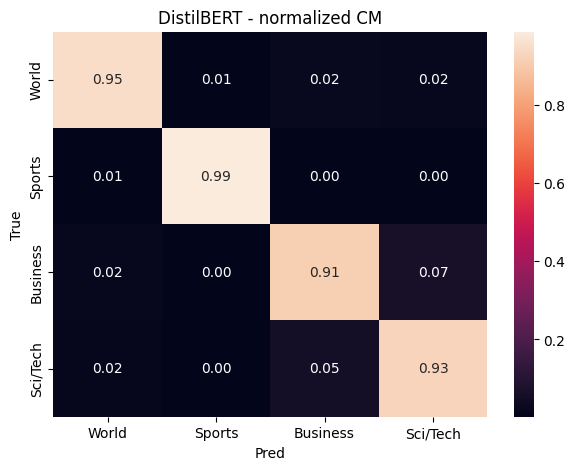

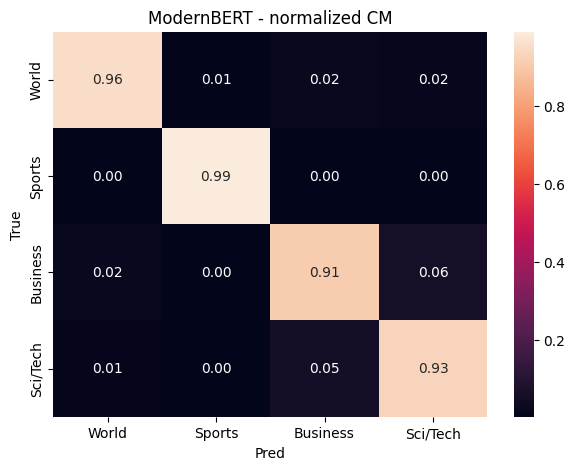

In [ ]:
# %% Confusion Matrix（normalized）
def plot_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(7,5))
    sns.heatmap(cmn, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_cm(y_true, y_pred_distil, label_names, "DistilBERT - normalized CM")
plot_cm(y_true_mod, y_pred_modern, label_names, "ModernBERT - normalized CM")

In [ ]:
import torch.nn.functional as F
# %% Error analysis: save misclassified samples and increase confidence level of misclassified samples
def make_error_df(pred_output, tokenizer, raw_test_ds):
    logits = pred_output.predictions
    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    preds = np.argmax(logits, axis=1)
    labels = pred_output.label_ids
    texts = raw_test_ds["text"]  # Original text
    df = pd.DataFrame({"text": texts, "true_id": labels, "pred_id": preds})
    df["true"] = df["true_id"].map(lambda x: label_names[x])
    df["pred"] = df["pred_id"].map(lambda x: label_names[x])
    # Confidence
    df["pred_conf"] = np.max(probs, axis=1)
    df_err = df[df["true_id"] != df["pred_id"]].copy()
    df_err = df_err.sort_values("pred_conf", ascending=False)
    return df_err

err_distil = make_error_df(pred_distil, tokenizer_distil, test_ds)
err_modern = make_error_df(pred_modern, tokenizer_modern, test_ds)

# Save the top 200 error samples as csv
err_distil.head(200).to_csv("errors_distil_top200.csv", index=False)
err_modern.head(200).to_csv("errors_modern_top200.csv", index=False)
print("Saved error CSVs.")

# Print several high-confidence but wrong examples
print("DistilBERT High-Confidence Misclassification Examples:")
display(err_distil.head(5)[["text","true","pred","pred_conf"]])
print("ModernBERT High-Confidence Misclassification Examples:")
display(err_modern.head(5)[["text","true","pred","pred_conf"]])

# %% Counting the types and number of errors made by DistilBERT
print("DistilBERT Error type statistics：")
display(err_distil.groupby(['true', 'pred']).size().sort_values(ascending=False).to_frame(name='count'))

# %% Counting the types and number of errors made by ModernBERT
print("ModernBERT Error type statistics：")
display(err_modern.groupby(['true', 'pred']).size().sort_values(ascending=False).to_frame(name='count'))

# %% Compare the misclassified sets of two models (intersection/difference)
set_distil_err_texts = set(err_distil["text"])
set_modern_err_texts = set(err_modern["text"])
unique_distil = set_distil_err_texts - set_modern_err_texts
unique_modern = set_modern_err_texts - set_distil_err_texts
common_err = set_distil_err_texts & set_modern_err_texts
print("DistilBERT Unique Misclassifications:", len(unique_distil))
print("ModernBERT Unique Misclassifications:", len(unique_modern))
print("Common Misclassifications:", len(common_err))

# Printing Example
print("DistilBERT Unique Examples (2 samples):")
for i,t in enumerate(list(unique_distil)[:2]): print(i+1, t)
print("ModernBERT Unique Examples (2 samples):")
for i,t in enumerate(list(unique_modern)[:2]): print(i+1, t)

Saved error CSVs.
DistilBERT High-Confidence Misclassification Examples:


,text,true,pred,pred_conf
912,Bryant Makes First Appearance at Trial (AP) AP...,Sci/Tech,Sports,0.999592
2126,Bush Scraps Most U.S. Sanctions on Libya (Reut...,Sci/Tech,World,0.999454
3688,Ljubicic Downs Hanescu at Open De Moselle Top-...,World,Sports,0.999177
1110,EU foreign ministers hope to break deadlock ov...,Business,World,0.999058
1197,World briefs LONDON - A man wielding a machete...,Business,World,0.999026


ModernBERT High-Confidence Misclassification Examples:


,text,true,pred,pred_conf
1197,World briefs LONDON - A man wielding a machete...,Business,World,0.999992
248,Caterpillar snaps up another remanufacturer of...,Sci/Tech,Business,0.999912
4396,Revolving Door &lt;em&gt; IN&lt;/em&gt;&lt;br...,World,Business,0.999908
4540,Miss Peru takes Miss World crown Twenty-year-o...,Sports,World,0.999901
6185,Special to ESPN.com It #39;s the age old quest...,Business,Sports,0.999897


DistilBERT Error type statistics：


,,count
true,pred,
Business,Sci/Tech,126
Sci/Tech,Business,100
World,Business,47
Business,World,35
World,Sci/Tech,35
Sci/Tech,World,31
Sports,World,11
World,Sports,10
Sports,Business,8


ModernBERT Error type statistics：


count
true     pred           
Business Sci/Tech    121
Sci/Tech Business    102
Business World        45
World    Business     42
         Sci/Tech     32
Sci/Tech World        25
World    Sports       11
Business Sports        8
Sci/Tech Sports        8
Sports   Business      8
         Sci/Tech      5
         World         5

DistilBERT Unique Misclassifications: 122
ModernBERT Unique Misclassifications: 115
Common Misclassifications: 297
DistilBERT Unique Examples (2 samples):
1 BearingPoint CFO Out; Error Found McLean technology consulting company BearingPoint Inc. said yesterday that its chief financial officer, Robert S. Falcone, would retire on Nov. 30.
2 EBay gets into rentals EBay plans to buy the apartment and home rental service Rent.com for \$415 million, adding to its already exhaustive breadth of offerings.
ModernBERT Unique Examples (2 samples):
1 Ryder Cup: Europe close on victory Another good day at Oakland Hills sees Europe move 11-5 clear of the USA going into Sunday's Ryder Cup singles.
2 EU Head Office Trims 2005 Growth Forecast (AP) AP - The European Union's head office issued a bleak economic report Tuesday, warning that the sharp rise in oil prices will "take its toll" on economic growth next year while the euro's renewed climb could threaten crucial exports.


In [ ]:
# %% Install word cloud library
!pip install wordcloud

In [ ]:
# %% Generate a word cloud for a specific error type

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
def plot_wordcloud(err_df, true_label, pred_label, model_name):

    target_errors_df = err_df[(err_df['true'] == true_label) & (err_df['pred'] == pred_label)]

    if not target_errors_df.empty:
        text_corpus = ' '.join(target_errors_df['text'].tolist())
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {true_label} -> {pred_label} Misclassifications ({model_name})')
        plt.show()

        print(f"Found {len(target_errors_df)} examples where '{true_label}' was misclassified as '{pred_label}'.")
    else:
        print(f"No error samples found for {true_label} -> {pred_label} in {model_name}.")

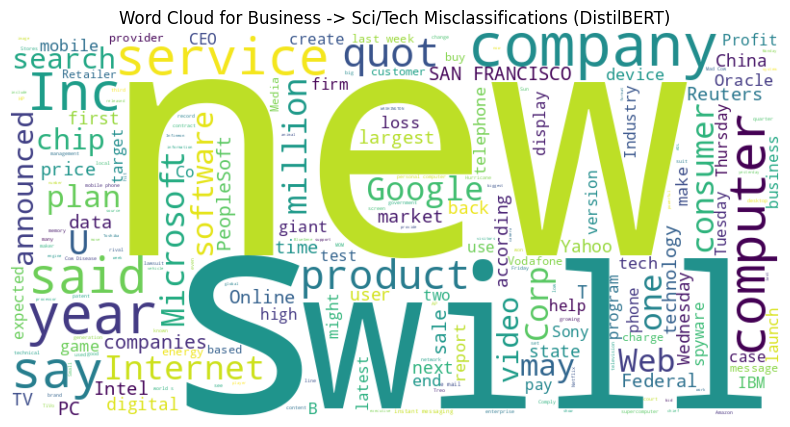

Found 121 examples where 'Business' was misclassified as 'Sci/Tech'.


In [ ]:
# DistilBERT: Business -> Sci/Tech
plot_wordcloud(err_distil, "Business", "Sci/Tech", "DistilBERT")

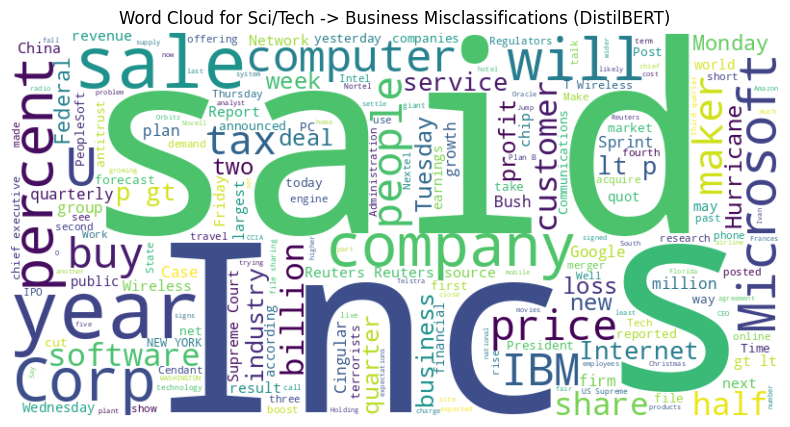

Found 100 examples where 'Sci/Tech' was misclassified as 'Business'.


In [ ]:
# DistilBERT: Sci/Tech -> Business
plot_wordcloud(err_distil, "Sci/Tech", "Business", "DistilBERT")

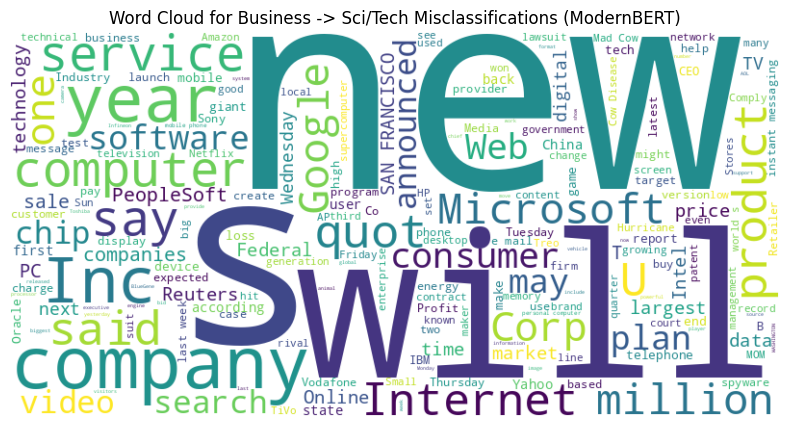

Found 121 examples where 'Business' was misclassified as 'Sci/Tech'.


In [ ]:
# ModernBERT: Business -> Sci/Tech
plot_wordcloud(err_modern, "Business", "Sci/Tech", "ModernBERT")

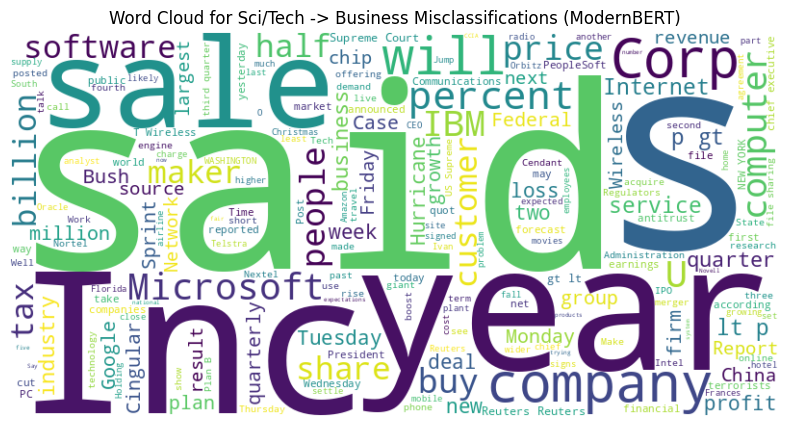

Found 100 examples where 'Sci/Tech' was misclassified as 'Business'.


In [ ]:
# ModernBERT: Sci/Tech -> Business
plot_wordcloud(err_modern, "Sci/Tech", "Business", "ModernBERT")